In [1]:
import numpy as np
import argparse
import csv
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
np.random.seed(42)
import math
import random
import seaborn as sns
sns.set_theme()

In [2]:
MAX_POWER = 11
SUBSET = 100
N_FOLDS = 10
ERROR = "mse"
REGULARIZATION_LAMBDA = 1e-4

In [3]:
def readData(filename):
    dataset = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        for row in csv_reader:
            dataset.append([float(row[0]),float(row[1])])
    return dataset
dataset = readData('non_gaussian_rg.csv')

In [4]:
dataset = dataset[:SUBSET]

In [5]:
# dataset = []
# for i in np.arange(0,2,0.02):
#     dataset.append([i,i*i*i*i-i*i*i-3*i*i+0.1*i+5])

In [6]:
def cross_validation_split(dataset):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / N_FOLDS)
    for i in range(N_FOLDS):
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [7]:
# highest power is m here
def makeDesignMat(x,m):
    return np.vander(x,m+1,increasing=True)

In [8]:
def chunkarr(arr,n):
    return [arr[i:i + n] for i in range(0, len(arr), n)]

In [9]:
def plot_error(train_err_list,test_err_list):
    xa = np.linspace(1,len(train_err_list),len(train_err_list),dtype=int)
    plt.figure()
    plt.plot(xa,train_err_list,color="g")
    plt.plot(xa,test_err_list,color="r")
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Error vs Iterations')
    plt.show()

In [10]:
def plot_reg(trainX,trainY,testX,testY,w):
    def aux(X_line,w):
        temp = 0
        for i in range(len(w)):
            temp += np.power(X_line,i) * w[i]
        return temp
    jointX = np.concatenate((trainX,testX))
    plt.scatter(trainX,trainY,color='b',marker ='o',s=15)
    plt.scatter(testX,testY,color="m",marker='o',s=30)
    x_line = np.linspace(min(jointX),max(jointX),100)
    y_pred = aux(x_line,w)
    plt.plot(x_line,y_pred, color='g')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.show()

In [11]:
def testError(testX, testY,w):
    testX = makeDesignMat(testX,MAX_POWER)
    pred = np.dot(testX,w)
    if ERROR == "mse":
        err = 0.5 * (np.sum(np.square(pred-testY)))/len(testY)
    elif ERROR == "mae":
        err = np.sum(np.abs(pred-testY)) / len(testY)
    elif ERROR == "huber":
        e = 0.1
        temp = pred-testY
        err = np.sum(np.where(np.abs(temp)<=e,0.5*temp*temp,(e*np.abs(temp) - 0.5*e*e))) / len(testY)
    return err

In [12]:
def evaluate_moorepenrose(dataset):
    folds = cross_validation_split(dataset)
    err_list = []
    for fold in folds:
        trainDS = list(folds)
        trainDS.remove(fold)
        trainDS = np.array(trainDS)
        trainX = []
        trainY = []
        for i in range(len(trainDS)):
            trainX.extend(trainDS[i][:,0])
            trainY.extend(trainDS[i][:,1])
        testDS = np.array(fold)
        testX = testDS[:,0]
        testY = testDS[:,1]
        X = makeDesignMat(trainX,MAX_POWER)
        #w = np.dot(np.linalg.inv(np.dot(X.transpose(),X)),np.dot(X.transpose(),trainY))
        w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
        plot_reg(trainX,trainY,testX,testY,w)
        err = testError(testX,testY,w)
        err_list.append(err)
    avg_error = np.mean(err_list)
    print(w)
    print(err_list)
    return avg_error

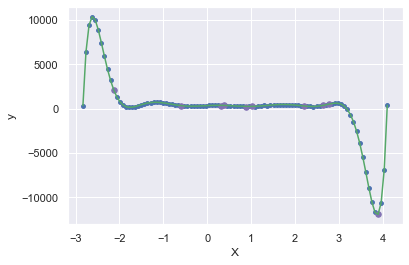

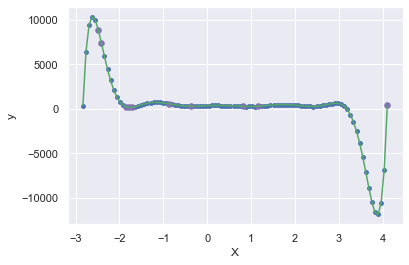

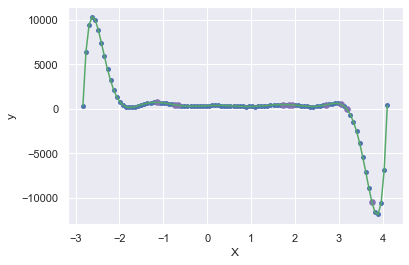

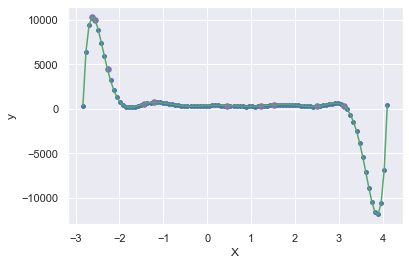

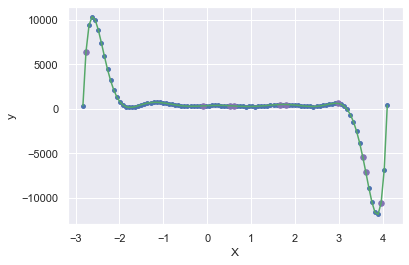

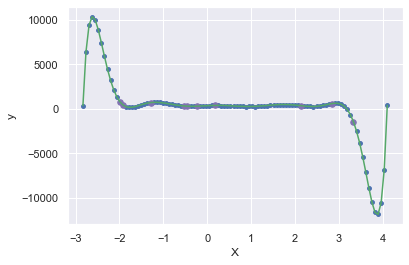

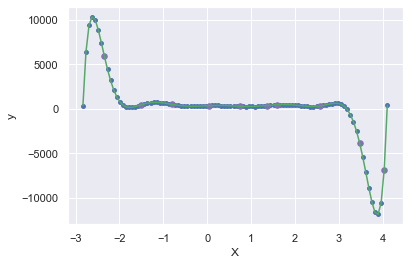

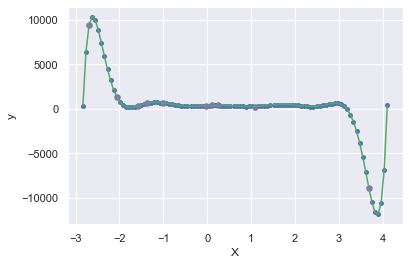

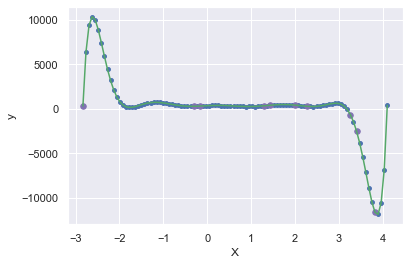

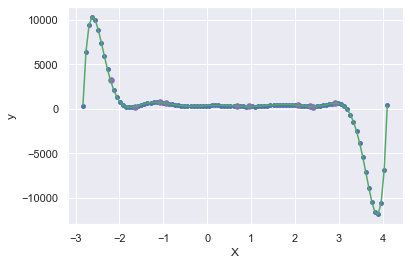

[ 354.48860318  232.73124955 -240.08562005 -901.9008647   708.22792491
  566.93955844 -451.56867078  -91.76839714  100.98469268   -3.7493109
   -6.88018259    1.00657699]
[565.8165552288876, 274.8120216391787, 272.266625438465, 163.52967886872165, 143.91643897071862, 131.46753483851043, 259.8382601544205, 244.499286499656, 333.1430753845583, 93.02730508032143]


248.23167821034386

In [13]:
evaluate_moorepenrose(dataset)

In [11]:
def evaluate_moorepenrose2(dataset,MAX_POWER):
    dataset = np.array(dataset)
    trainDS = dataset[:18]
    testDS = dataset[18:]
    trainX = trainDS[:,0]
    trainY = trainDS[:,1]
    testX = testDS[:,0]
    testY = testDS[:,1]
    X = makeDesignMat(trainX,MAX_POWER)
    print(REGULARIZATION_LAMBDA)
    w = np.dot(np.linalg.inv(np.dot(X.transpose(),X) + REGULARIZATION_LAMBDA * np.identity(MAX_POWER+1) ),np.dot(X.transpose(),trainY))
    plt = plot_reg(trainX,trainY,testX,testY,w)
    plt.title(f"Moore Penrose with m={MAX_POWER}")
#         if j==0:
#             plt.savefig(f"Moore Penrose with m={MAX_POWER}.png",dpi=1200)
    trainerr = testError(trainX,trainY,w,MAX_POWER)
    testerr = testError(testX,testY,w,MAX_POWER)
    return w,testerr,trainerr

In [30]:
def pseudoInv(X,t):
    pseudoInverse=np.linalg.pinv(X)
    weights=pseudoInverse @ t
    return(weights)
ds = np.array(dataset)
finw = pseudoInv(makeDesignMat(ds[:,0],MAX_POWER),ds[:,1])

In [33]:
finw

array([ 353.38806562,  230.35376988, -238.15567935, -898.57188426,
        706.65168689,  565.5505144 , -450.99873214,  -91.57544575,
        100.89659959,   -3.75416649,   -6.87542445,    1.00613667])

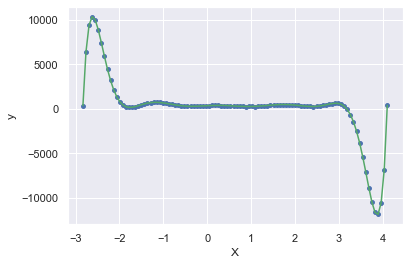

In [32]:
plot_reg(ds[:,0],ds[:,1],[],[],finw)

Mean of noise is: -1.024598560661616e-08
Standard deviation of noise is: 19.415032082206412


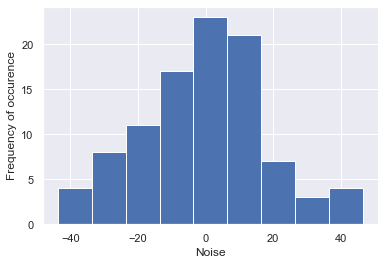

In [24]:
def getNoisePlot(trainX,trainY,w):
    trainX = makeDesignMat(trainX,MAX_POWER)
    preds = np.dot(trainX,w)
    noise = trainY-preds
    print(f"Mean of noise is: {np.mean(noise)}")
    print(f"Standard deviation of noise is: {np.std(noise)}")
    plt.hist(noise, bins=np.arange(noise.min(),noise.max()+1,10))
    plt.xlabel("Noise")
    plt.ylabel("Frequency of occurence")
getNoisePlot(ds[:,0],ds[:,1],finw)

In [29]:
MAX_POWER = 11
SUBSET = 100
N_FOLDS = 10
ERROR = "mse"
REGULARIZATION_LAMBDA = 1e-4